In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = "D:/Research/PlantVillage"
width=256
height=256
depth=3

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    plant_folders = listdir(directory_root)
    for plant_folder in plant_folders :
            print(f"[INFO] Processing {plant_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/")
                
            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Image loading completed


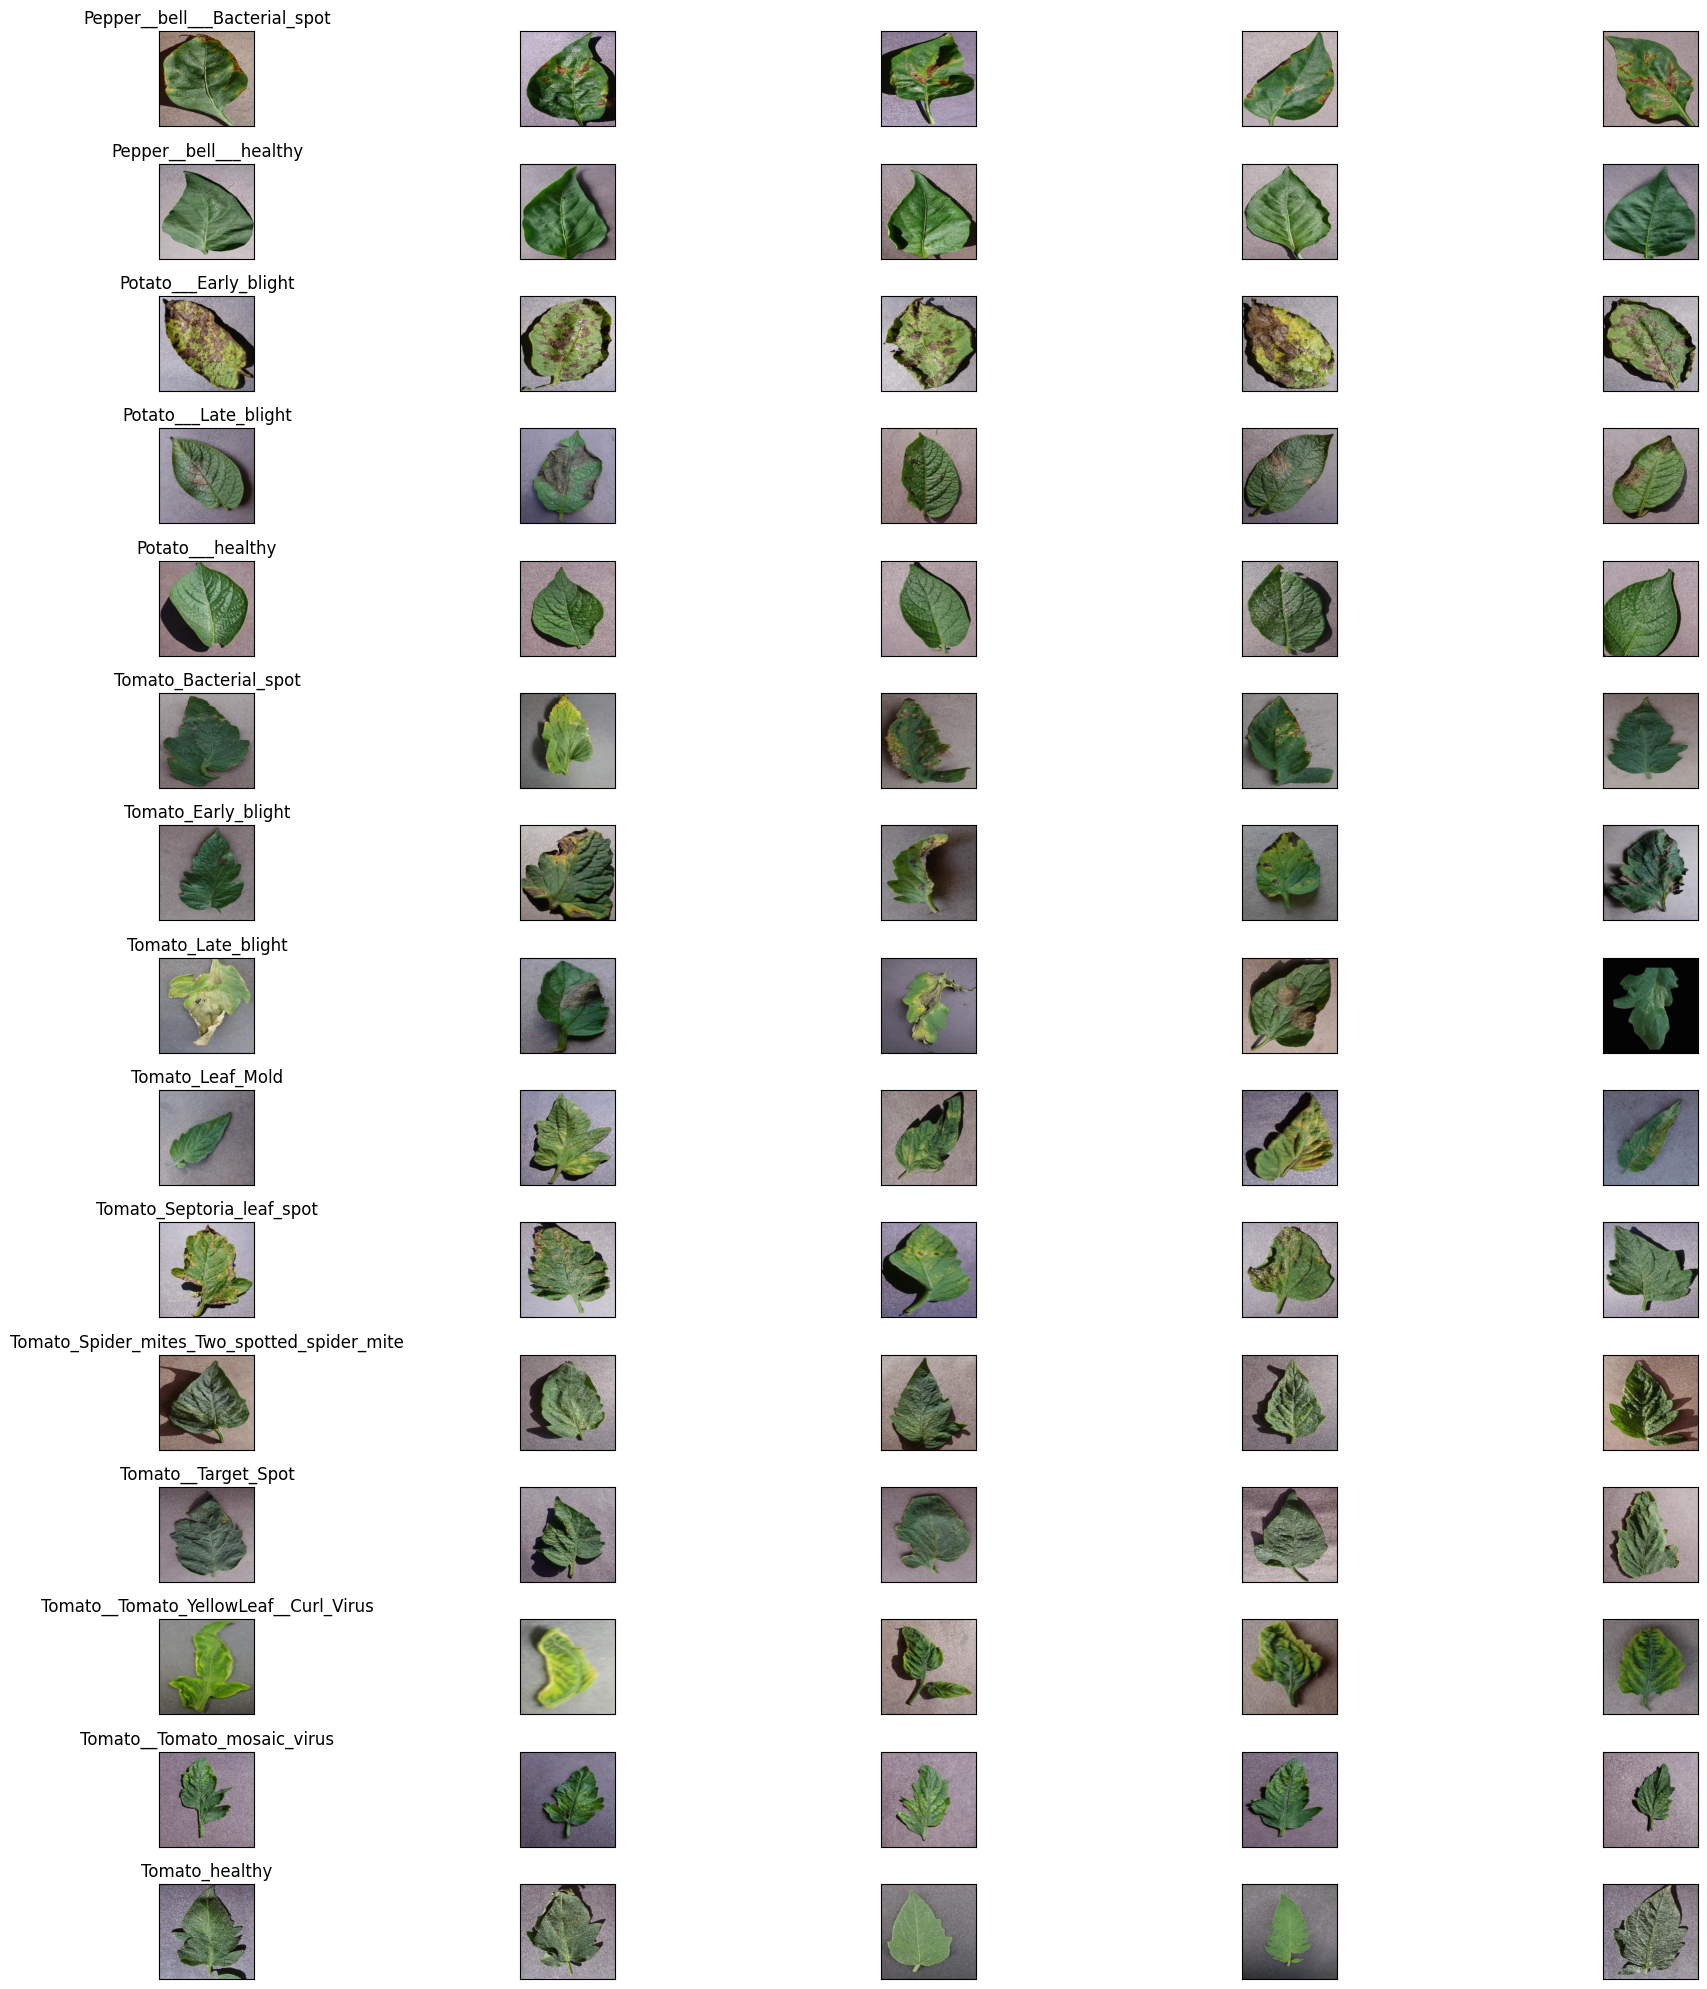

In [5]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

data_dir = "D:/Research/PlantVillage"
class_names = sorted(os.listdir(data_dir))

num_rows = len(class_names)  
num_cols = 5 

plt.figure(figsize=(20, 20))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    image_files = [os.path.join(class_dir, file) for file in os.listdir(class_dir)]
    image_files_subset = random.sample(image_files, min(num_cols, len(image_files)))
    for j, image_file in enumerate(image_files_subset):
        img = mpimg.imread(image_file)
        plt.subplot(num_rows, num_cols, i * num_cols + j + 1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
        if j == 0:
            plt.title(class_name)

plt.tight_layout()
plt.show()


In [5]:
image_size = len(image_list)

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [8]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [9]:
def manual_train_test_split(X, y, test_size=0.2, random_state=None):
    y = np.array(y)
    if random_state is not None:
        np.random.seed(random_state)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    num_test_samples = int(test_size * len(X))
    test_indices = indices[:num_test_samples]
    train_indices = indices[num_test_samples:]
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test


In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = manual_train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [12]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 activation (Activation)     (None, 256, 256, 32)      0         
                                                                 
 batch_normalization (Batch  (None, 256, 256, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 85, 85, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 85, 85, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        1

In [14]:
opt = Adam(learning_rate=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
print("[INFO] training network...")

[INFO] training network...


In [15]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

C:\Users\HP\AppData\Local\Temp\ipykernel_9172\1273247788.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/25


73/73 [==============================] - 163s 2s/step - loss: 0.6021 - accuracy: 0.2365 - val_loss: 1.4340 - val_accuracy: 0.1288
Epoch 2/25
73/73 [==============================] - 153s 2s/step - loss: 0.1963 - accuracy: 0.4704 - val_loss: 1.7028 - val_accuracy: 0.0644
Epoch 3/25
73/73 [==============================] - 278s 4s/step - loss: 0.1340 - accuracy: 0.6313 - val_loss: 0.6574 - val_accuracy: 0.0678
Epoch 4/25
73/73 [==============================] - 153s 2s/step - loss: 0.1479 - accuracy: 0.5858 - val_loss: 9.6782 - val_accuracy: 0.0831
Epoch 5/25
73/73 [==============================] - 165s 2s/step - loss: 0.1945 - accuracy: 0.5326 - val_loss: 0.9496 - val_accuracy: 0.2186
Epoch 6/25
73/73 [==============================] - 143s 2s/step - loss: 0.1839 - accuracy: 0.5828 - val_loss: 0.6684 - val_accuracy: 0.2661
Epoch 7/25
73/73 [==============================] - 152s 2s/step - loss: 0.1667 - accuracy: 0.6082 - val_loss: 2.6001 - val_accuracy: 0.0729
Epoch 8/25


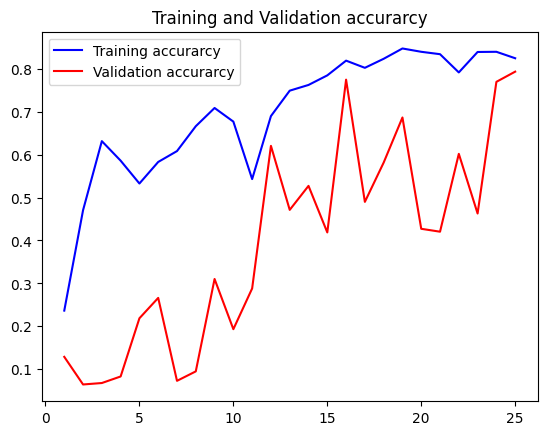

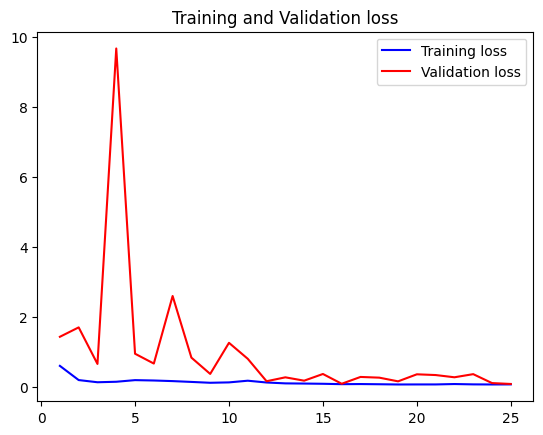

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [9]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import load_img, img_to_array
from PIL import UnidentifiedImageError 

# Load the pretrained model from the .pkl file
with open("D:/Research/Misc/cnnmodel.pkl", 'rb') as f:
    model = pickle.load(f)

# Set the path to the directory containing your images
data_dir = "D:/Research/PlantVillage"

# Get the list of class names (folder names)
class_names = sorted(os.listdir(data_dir))

# Initialize lists to store images and true labels
X = []
y_true = []

# Iterate over each class folder
for i, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    
    # Iterate over each image in the class folder
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        try:
            # Load the image, resize if necessary, and convert to numpy array
            img = load_img(img_path, target_size=(224, 224))  # Adjust target_size as needed
            img_array = img_to_array(img)
            
            # Append image and true label to lists
            X.append(img_array)
            y_true.append(i)  # Use class index as label
        
        # If unable to load the image, skip it and continue with the next image
        except UnidentifiedImageError:
            print(f"Skipping {img_path} - UnidentifiedImageError")

# Convert lists to numpy arrays
X = np.array(X)
y_true = np.array(y_true)

# Make predictions on the data
predictions = model.predict(X)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Skipping D:/Research/PlantVillage\Tomato__Tomato_YellowLeaf__Curl_Virus\svn-r6Yb5c - UnidentifiedImageError


KeyboardInterrupt: 

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 8s 430ms/step - loss: 0.0849 - accuracy: 0.7932
Test Accuracy: 79.32203412055969


In [18]:
print("[INFO] Saving model...")
pickle.dump(model,open('cnnmodel.pkl', 'wb'))

[INFO] Saving model...
